# State Farm Distracted Driver Detection


## Objective

This is an old competition from [Kaggle](https://www.kaggle.com/competitions/state-farm-distracted-driver-detection/overview).


In this competition, we are given driver images, each taken in a car with a driver doing something in the car (texting, eating, talking on the phone, makeup, reaching behind, etc). Our goal is to predict the likelihood of what the driver is doing in each picture.

The 10 classes to predict are:

- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

## File descriptions

- `imgs` - Folder of all (train/test) images
- `sample_submission.csv` - a sample submission file in the correct format
- `driver_imgs_list.csv` - a list of training images, their subject (driver) id, and class id
In our case, we are going to use only the images from the `train` folder present inside the `imgs` folder.

## Outline of the model used:
In our project, we have trained the dataset using the following model:
- **Yolo v8 Model**
Our Model is trained till `15Epochs`.

## Spliting Approach

Apart from that, we have used two method for creating directories for training set, validation set and test set. One, with our standard `os` module and other using simpler method by taking the benefit of `splitfolders` module

*Below lines were used to install `ultralytics`, `split-folders` Module. We will be using them for YoLo Model and for spliting our datasets respectively*

In [27]:
!pip install ultralytics
!pip install split-folders
!pip install -U ipywidgets
!pip install tensorflow-cpu
!pip install wandb


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 MB 3.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 10.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.0 MB/s eta 0:00:000:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
ERROR: pip's dependency resolver does not currently take into

#### *Importing all the libraries that we will be requiring during our project*

In [28]:
import csv
import os
from glob import glob
from shutil import copyfile
from random import shuffle, seed
import splitfolders
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from ultralytics import YOLO
import pandas as pd
import numpy as np
from IPython.display import display, Image
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

## Let us load our data and explore it a bit


As per the dataset below, we have `22424` images in the `training dataset`. We are gonna split it in three sets (train, val and test), respectively We will ignore `testing dataset` as we don't have any labels for them.

In [29]:
data = {}

with open('/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv') as file:
    read_file = csv.reader(file)
    read_file = list(read_file)

    for row in read_file[1:]:
        key = row[1]
        if key in data:
            data[key].append(row[2])
        else:
            data[key] = [row[2]]

In [30]:
data['c0'][:5]

['img_44733.jpg',
 'img_72999.jpg',
 'img_25094.jpg',
 'img_69092.jpg',
 'img_92629.jpg']

We have 10 classes in total (`c0`, `c1`, `c2`, `c3`, `c4`, `c5`, `c6`, `c7`, `c8`, `c9`)

In [31]:
classes_list = list(data.keys())
classes_list

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [32]:
dataset_folder = '/kaggle/input/state-farm-distracted-driver-detection/imgs/'

train_dir = os.path.join(dataset_folder, 'train/')
test_dir = os.path.join(dataset_folder, 'test/')

In [33]:
print('Number of images in the training dataset : ', str(len(glob(train_dir+'*/*'))))
print('Number of images in the testing dataset : ', str(len(glob(test_dir+'*'))))

Number of images in the training dataset :  22424
Number of images in the testing dataset :  79726


## Reducing our dataset

For the sake of simplicity and to reduce the overall time taken to train all our model,we will reduce our dataset by 1/5th.

#### *Note: In case you are testing only one or two model. I would recommend to use whole dataset and use more layers in your models*

In [34]:
dataset_small_folder_path = '/kaggle/working/state-farm-distracted-driver-detection/smallset'
subfolders = classes_list

if os.path.exists(dataset_small_folder_path):
    for root, dirs, files in os.walk(dataset_small_folder_path, topdown = False):
        for name in files:
            file_path = os.path.join(root, name)
            os.remove(file_path)
        for name in dirs:
            dir_path = os.path.join(root, name)
            os.rmdir(dir_path)
    os.rmdir(dataset_small_folder_path)

for folder in subfolders:
            subfolder_path = os.path.join(dataset_small_folder_path, folder)
            os.makedirs(subfolder_path)


In [35]:
for clas, images in data.items():
    length = len(images)
    seed(42)
    shuffle(images)
    for image in images[:int(length*0.2)]:
        source = os.path.join(dataset_folder, 'train/', clas, image)
        #print(source)
        destination = os.path.join(dataset_small_folder_path, clas, image)
        copyfile(source, destination)

In [36]:
print(dataset_small_folder_path)
for subfolder in subfolders:
    subfolder_path = os.path.join(dataset_small_folder_path, subfolder)
    print("Number of images for each class: ", subfolder, "->", len(os.listdir(subfolder_path)))

/kaggle/working/state-farm-distracted-driver-detection/smallset
Number of images for each class:  c0 -> 497
Number of images for each class:  c1 -> 453
Number of images for each class:  c2 -> 463
Number of images for each class:  c3 -> 469
Number of images for each class:  c4 -> 465
Number of images for each class:  c5 -> 462
Number of images for each class:  c6 -> 465
Number of images for each class:  c7 -> 400
Number of images for each class:  c8 -> 382
Number of images for each class:  c9 -> 425


In [37]:
small_dataset = {}
for subfolder in os.listdir(dataset_small_folder_path):
    small_dataset[subfolder] = os.listdir(os.path.join(dataset_small_folder_path, subfolder))

## Spliting Approach1 - For creating directories for training set, validation set and test set, using `os` and `shutil` modules

#### Writing helper function for creating directories for training set, validation set and test set
- `remove_directory` :- Removes the folder, subfolder and files within it
- `create_directories` :- Creates the folder and classes subfolders in each folder in the following order
    - `Folder`:- train or val or test
    - `Subfolders`:- All labeled classes *(('c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'))*
    
**Note for the shake of simplicity and for reducing the total run time, we will reduce our dataset by the margin of ten.**

In [38]:
def remove_directory(path):
    for root, dirs, files in os.walk(path, topdown = False):
        for name in files:
            file_path = os.path.join(root, name)
            os.remove(file_path)
        for name in dirs:
            dir_path = os.path.join(root, name)
            os.rmdir(dir_path)
    os.rmdir(path)

In [39]:
def create_directories(paths, subfolders):
    for path in paths:
        if os.path.exists(path):
            remove_directory(path)

        for folder in subfolders:
            subfolder_path = os.path.join(path, folder)
            os.makedirs(subfolder_path)

#### We will store the path for the cleaned dataset containing train, val and test datasets in `paths` list and classes in subfolder list

In [40]:
paths = ['/kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/train',
         '/kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/val',
        '/kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/test']

In [41]:
subfolders = classes_list

### Creating Train, Val, Test folders along with sub-directories (all Classes)

In [42]:
create_directories(paths, subfolders)

### Copying the image files to the cleaned dataset we have created using the above helper functions

Our dataset is splited in the following order using the `copyfile` submodule from the `shutil` module:
- Train -> 80%
- Test, Val -> 10% each

In [43]:
split_size = [0.8, 0.1]


for clas, images in small_dataset.items():
    # print(len(images))
    train_size = int(split_size[0]*len(images))
    # print("Train size: ", train_size)

    test_size = int(split_size[1]*len(images))
    #print("Test size: ", test_size)

    train_images = images[:train_size]
    # print("Train Images Length", len(train_images))

    val_images = images[train_size: train_size + test_size]
    # print("Val Images Length", len(val_images))

    test_images = images[train_size + test_size:]
    # print("Test Images Length", len(test_images))



    for image in train_images:
        source = os.path.join(train_dir, clas, image)
        # print(os.path.exists(source))
        dest = os.path.join(paths[0], clas, image)
        copyfile(source, dest)

    for image in val_images:
        source = os.path.join(train_dir, clas, image)
        dest = os.path.join(paths[1], clas, image)
        copyfile(source, dest)

    for image in test_images:
        source = os.path.join(train_dir, clas, image)
        dest = os.path.join(paths[2], clas, image)
        copyfile(source, dest)

## Spliting Approach2 -  For creating directories for training set, validation set and test set, using `splitfolders` module

We will use a better approach for creating the cleaned dataset using splitfolders module.

Let us first delete the cleaned dataset created using the above function `create_directories()` and `copyfile` submodule

In [44]:
remove_directory('/kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset')

### Creating the cleaned dataset now using splitfolder module.

The original dataset is splited in the following order and test, val, train subdirectories have been created automatically :
- Train -> 90%
- Test, Val -> 10% each

In [45]:
images_dir = '/kaggle/working/state-farm-distracted-driver-detection/smallset'
output_folder = '/kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset'

split_ratio = (0.8, 0.1, 0.1)

# Note: the module will create val, train, test sub directories by itself in the background.
# No need for us to create those.
splitfolders.ratio(images_dir, output= output_folder, seed = 42, ratio= split_ratio)

Copying files: 4481 files [00:00, 5434.55 files/s]


#### Done ! Just needed one line of code.

#### Let us keep all our directory paths together at one place.
From now on, these Directory paths will be used for our training, validation and testing purpose

In [46]:
parent_dir = '/kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset'
train_dir = '/kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/train'
val_dir = '/kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/val'
test_dir = '/kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/test'

## Creating Function using Tensorflow's `ImageDataGenerator` Module for our image preprocessing

`imagedatageneration` function will be created that will return three generated batches of tensor image-data namely:-
- train_generator (generated from our train folder)
- val_generator (generated from our val folder)
- test_generator (generated from our test folder)

*Note: We will leverage the Data Augmentation facility of ImageDataGenerator module in training our model*

In [47]:
def imagedatageneration(train_dir, val_dir, test_dir, target_size = (256, 256), batch_size = 64):


    ## It can be seen that the augmentation is applied only on the training set.
    ## We have skipped it for val because it is not recommended. But we can try and experiment with it later

    train_datagen = ImageDataGenerator(rescale = 1.0 / 255,
                                       rotation_range = 30,
                                       width_shift_range = 0.1,
                                       height_shift_range = 0.1,
                                       zoom_range = 0.1,
                                       shear_range = 0.1,
                                       fill_mode = "nearest"
                                      )
    train_generator = train_datagen.flow_from_directory(
                                                            train_dir,
                                                            target_size = target_size,
                                                            class_mode = 'categorical',
                                                            shuffle = True,
                                                            batch_size = batch_size
                                                        )


    val_datagen = ImageDataGenerator(rescale = 1.0 / 255)

    val_generator = val_datagen.flow_from_directory(
                                                        val_dir,
                                                        target_size = target_size,
                                                        class_mode = 'categorical',
                                                        shuffle = True,
                                                        batch_size = batch_size
                                                    )

    test_datagen = ImageDataGenerator(rescale = 1.0/255)
    test_generator = test_datagen.flow_from_directory(
                                                        test_dir,
                                                        target_size = target_size,
                                                        class_mode = 'categorical',
                                                        shuffle = False,
                                                        batch_size = 1
                                                      )

    return train_generator, val_generator, test_generator

#### *`es` object is created using the EarlyStopping Class which will stop training when a monitored metric has stopped improving. We are monitoring validation accuracy in this case*

In [48]:
es = EarlyStopping(monitor = "val_acc",
                    min_delta = 0.0001,
                    verbose=1,
                    patience = 5,
                    restore_best_weights = True,
                    baseline = None)

#### `train_val_plot` function will compare the behaviour of Train and Validation Accuracies and Losses on each epoch for each of our Model

In [49]:
def train_val_plot(model, model_name):
    train_loss, train_acc, val_loss, val_acc = model.history['loss'], model.history['acc'], model.history['val_loss'], model.history['val_acc']

    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title('{} Model Accuracy'.format(model_name))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper left')
    plt.show()


    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('{} Model Loss'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper left')
    plt.show()


## Yolo v8




### Creating the object of out Yolo model

In [50]:
model5 = YOLO('yolov8n-cls.pt')

100%|██████████| 5.31M/5.31M [00:00<00:00, 71.8MB/s]


#### Below we have trained our `YOLO` model with `20 epochs` on the training dataset we have created

In [51]:
# Import wandb and log in
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
my_secret = user_secrets.get_secret("wandb_api_key")



# Log in to wandb with API key
wandb.login(key=my_secret)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kababizid (kababizid-higher-institute-of-information-technologies-a). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [52]:
results = model5.train(data = parent_dir, epochs = 15)

Ultralytics 8.3.50 🚀 Python-3.10.15 torch-2.4.0+cu121 CPU (Intel Xeon 2.00GHz)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset, epochs=15, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fals

train: Scanning /kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/train... 3582 images, 0 corrupt: 100%|██████████| 3582/3582 [00:01<00:00, 2125.77it/s]

train: New cache created: /kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/train.cache



val: Scanning /kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/val... 444 images, 0 corrupt: 100%|██████████| 444/444 [00:00<00:00, 2290.58it/s]


val: New cache created: /kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/classify/train
Starting training for 15 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/15         0G      2.276         16        224:   1%|          | 2/224 [00:00<01:00,  3.69it/s]

       1/15         0G      2.322         16        224:   1%|▏         | 3/224 [00:00<00:57,  3.85it/s]
100%|██████████| 755k/755k [00:00<00:00, 17.4MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]

                   all      0.793      0.973



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]

                   all      0.914      0.998



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]

                   all      0.921      0.998



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]

                   all      0.955          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:03<00:00,  4.22it/s]

                   all      0.953          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


      10/15         0G     0.1596         14        224: 100%|██████████| 224/224 [00:50<00:00,  4.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


      11/15         0G     0.1393         14        224: 100%|██████████| 224/224 [00:49<00:00,  4.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


      12/15         0G     0.1558         14        224: 100%|██████████| 224/224 [00:50<00:00,  4.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


      13/15         0G     0.1223         14        224: 100%|██████████| 224/224 [00:50<00:00,  4.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


      14/15         0G       0.12         14        224: 100%|██████████| 224/224 [00:51<00:00,  4.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


      15/15         0G     0.1292         14        224: 100%|██████████| 224/224 [00:52<00:00,  4.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]

                   all      0.989          1



15 epochs completed in 0.227 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.50 🚀 Python-3.10.15 torch-2.4.0+cu121 CPU (Intel Xeon 2.00GHz)
YOLOv8n-cls summary (fused): 73 layers, 1,447,690 parameters, 0 gradients, 3.3 GFLOPs
train: /kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/train... found 3582 images in 10 classes ✅ 
val: /kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/val... found 444 images in 10 classes ✅ 
test: /kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/test... found 455 images in 10 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 14/14 [00:03<00:00,  4.44it/s]


                   all      0.986          1
Speed: 0.0ms preprocess, 1.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train


In [53]:
model5.save()

In [54]:
model=YOLO('/kaggle/working/saved_model.pt')

#### Validating our model performance on the validation dataset

In [55]:
model5.val()

Ultralytics 8.3.50 🚀 Python-3.10.15 torch-2.4.0+cu121 CPU (Intel Xeon 2.00GHz)
YOLOv8n-cls summary (fused): 73 layers, 1,447,690 parameters, 0 gradients, 3.3 GFLOPs
train: /kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/train... found 3582 images in 10 classes ✅ 
val: /kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/val... found 444 images in 10 classes ✅ 
test: /kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/test... found 455 images in 10 classes ✅ 


val: Scanning /kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/val... 444 images, 0 corrupt: 100%|██████████| 444/444 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 28/28 [00:03<00:00,  8.62it/s]


                   all      0.986          1
Speed: 0.0ms preprocess, 1.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aed5a160d60>
curves: []
curves_results: []
fitness: 0.9932432472705841
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9864864945411682, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9932432472705841}
save_dir: PosixPath('runs/classify/train2')
speed: {'preprocess': 0.0011346361658594632, 'inference': 1.8053811949652594, 'loss': 0.00014605822863879503, 'postprocess': 0.00037481118966867255}
task: 'classify'
top1: 0.9864864945411682
top5: 1.0

In [56]:
df= pd.read_csv('/kaggle/working/runs/classify/train/results.csv')
df.head()

,epoch,time,train/loss,metrics/accuracy_top1,metrics/accuracy_top5,val/loss,lr/pg0,lr/pg1,lr/pg2
0,1,56.2714,2.07135,0.79279,0.97297,1.04896,0.000237,0.000237,0.000237
1,2,110.3780,0.84240,0.91441,0.99775,0.30932,0.000444,0.000444,0.000444
2,3,163.8770,0.47607,0.92117,0.99775,0.23785,0.000619,0.000619,0.000619
3,4,217.4900,0.38030,0.94369,1.00000,0.15584,0.000573,0.000573,0.000573
4,5,270.8420,0.27529,0.95495,1.00000,0.13820,0.000526,0.000526,0.000526


#### Comparison of Train and Validation Losses for our Model

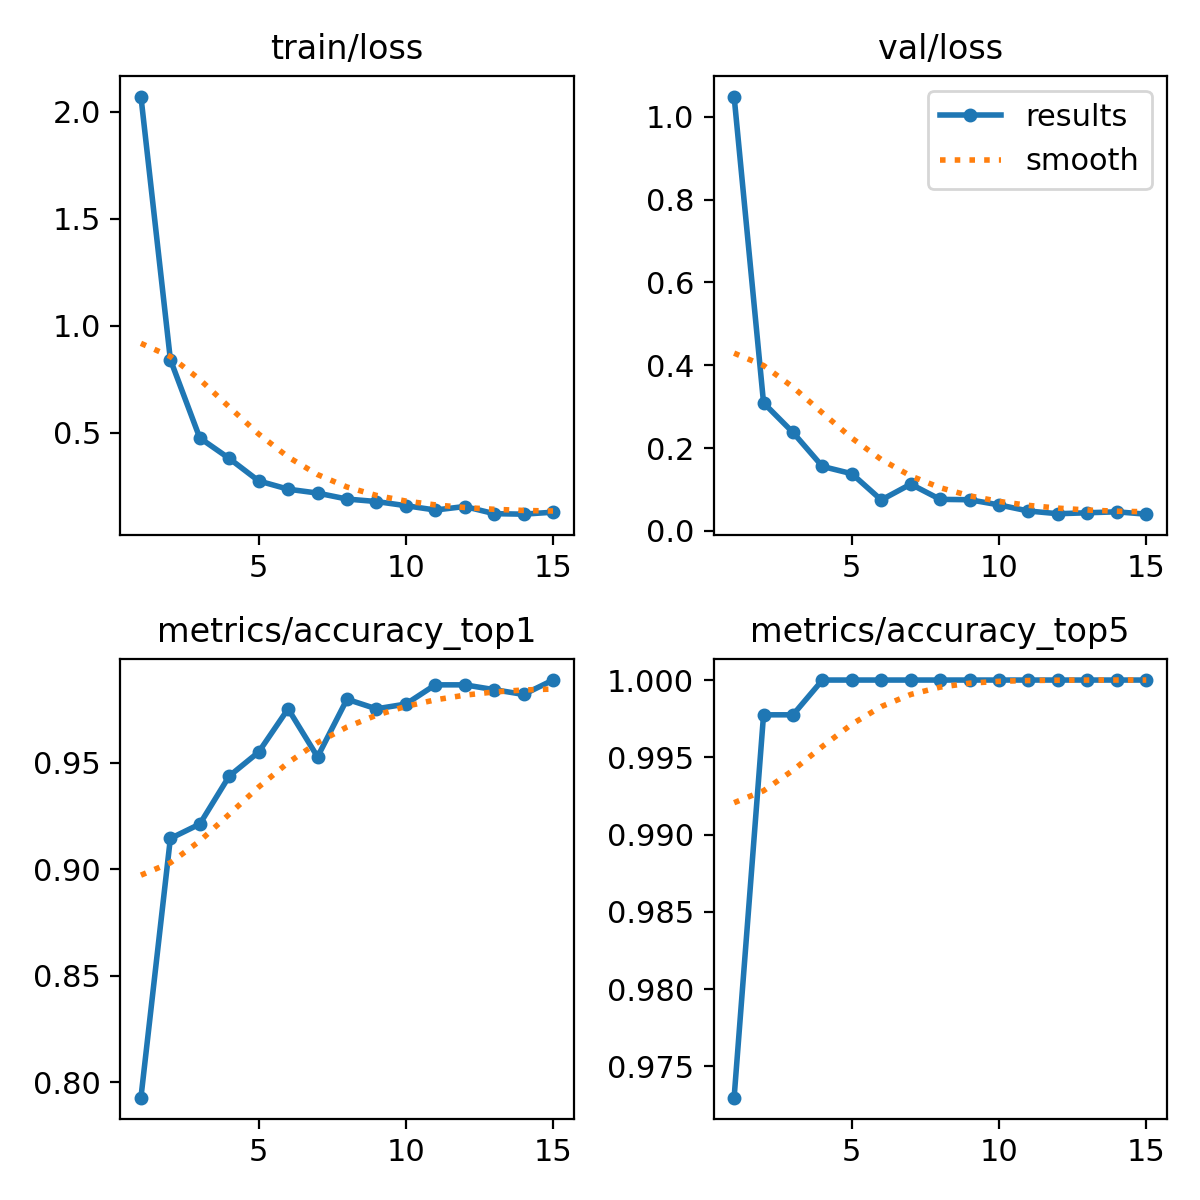

In [57]:
Image("/kaggle/working/runs/classify/train/results.png")

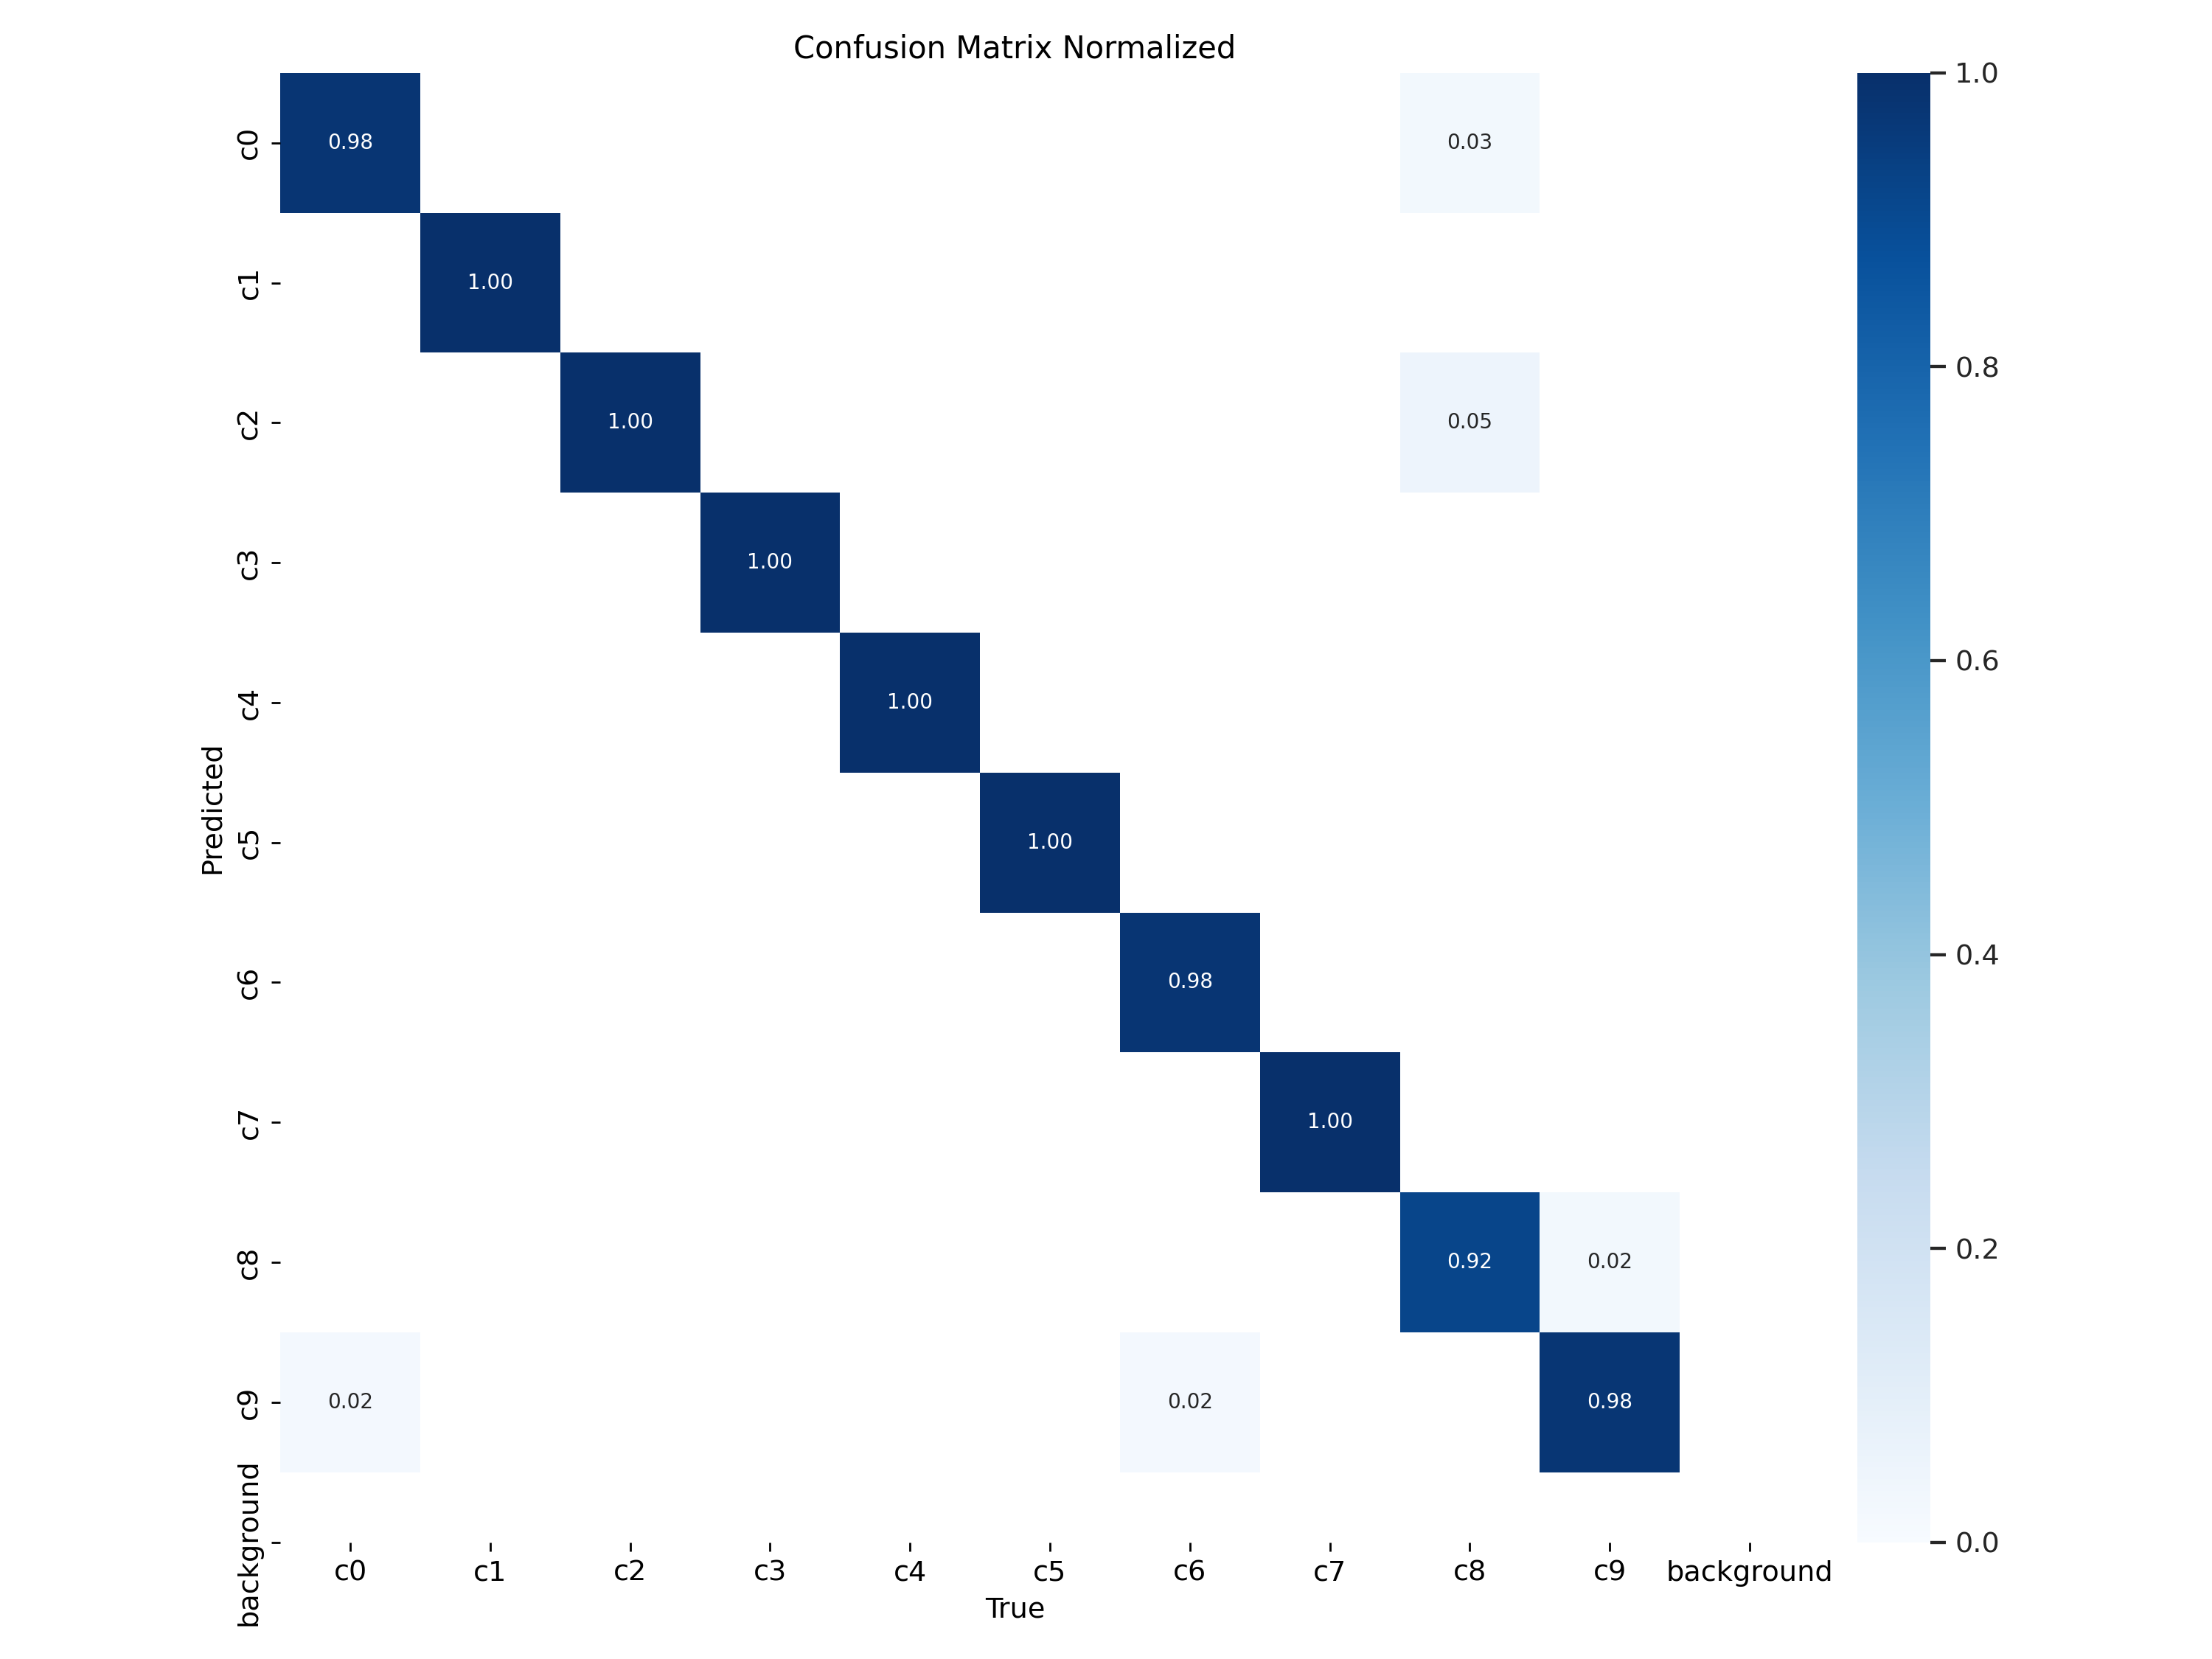

In [58]:
Image("/kaggle/working/runs/classify/train/confusion_matrix_normalized.png")

### Predicting our model performance on the test dataset we have created.

Below we compare the test images one by one and compare the result with their original class.

Overall accuracy came out `99.44%` on our test dataset.

In [59]:
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
test_images_path = test_dir
model_weights = "/kaggle/working/runs/classify/train/weights/best.pt"

predicted_list = []

for clas in classes:
    image_dir = os.path.join(test_images_path, clas)
    # print(image_dir)
    images_list = os.listdir(image_dir)
    # print(images_list)
    # Class label in the form of 0 to 9
    class_label = int(clas[-1])
    # print(class_label)
    for image in images_list:
        path = os.path.join(image_dir, image)
        # print(path)
        y_actual = class_label
        y_predicted = model5.predict(path, model = model_weights)[0].probs.top1
        predicted_list.append([path, y_actual, y_predicted])


image 1/1 /kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_42698.jpg: 224x224 c0 0.94, c9 0.06, c5 0.00, c8 0.00, c4 0.00, 17.1ms
Speed: 9.4ms preprocess, 17.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_37575.jpg: 224x224 c0 1.00, c9 0.00, c5 0.00, c1 0.00, c3 0.00, 9.7ms
Speed: 4.7ms preprocess, 9.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_80584.jpg: 224x224 c0 1.00, c3 0.00, c4 0.00, c5 0.00, c9 0.00, 9.6ms
Speed: 4.5ms preprocess, 9.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /kaggle/working/state-farm-distracted-driver-detection/cleaned_dataset/test/c0/img_65097.jpg: 224x224 c0 1.00, c1 0.00, c9 0.00, c2 0.00, c3 0.00, 9.3ms
Speed: 4.6ms preprocess, 9.3ms inference, 0.0ms postpr

In [60]:
print("length of the Predicted List : ", len(predicted_list))

length of the Predicted List :  455


In [61]:
df = pd.DataFrame(predicted_list, columns = ['Image_path', 'Y_actual', 'Y_predicted'])

In [62]:
print("Accuracy based on our YOLO V8 Model :- {:.2f}%".format(accuracy_score(df['Y_actual'], df['Y_predicted'])*100))

Accuracy based on our YOLO V8 Model :- 98.46%


## Conclusion

In our project, we have used two method for creating directories for training set, validation set and test set. One, with our standard `os` module and other using simpler method by taking the benefit of `splitfolders` module.


- **Yolo v8 Model** - Test Acc. (**98.46%**)